# Patternextractor

This is a new feature extraction technique employing an optimization algorithm to find helpful spatial/temporal patterns for a particular dataset and ML model.
In this script the patternextractor algorithm is applied on the following datasets:
1. MIT-BIH arrhythmia dataset

After feature extraction we showcase the utility of this approach by visualizing the features and displaying the feature importances.

## Import libraries

In [2]:
import os
import csv
from sklearn.model_selection import train_test_split
import numpy as np
from pyswarm import pso
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from imblearn.under_sampling import RandomUnderSampler
import warnings
import random
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("data_20.csv")
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
data

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,927,927,939,958,980,1010,1048,1099,1148,1180,...,1177,1128,1058,991,951,937,939,950,958,0
1,917,923,941,964,992,1021,1071,1122,1168,1199,...,1205,1175,1122,1057,1002,970,946,934,929,0
2,920,913,910,919,943,974,1006,1048,1106,1162,...,1216,1194,1128,1034,960,924,923,935,941,0
3,895,898,909,925,947,970,1001,1042,1098,1151,...,1196,1178,1119,1037,963,924,920,929,942,0
4,921,911,913,929,953,980,1013,1061,1119,1165,...,1180,1131,1053,984,940,924,928,934,942,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100054,960,970,989,1013,1049,1099,1158,1224,1287,1340,...,1366,1329,1266,1191,1111,1046,999,973,963,0
100055,972,987,1008,1032,1077,1128,1192,1255,1313,1347,...,1339,1295,1232,1160,1090,1033,994,970,962,0
100056,957,967,982,1008,1048,1091,1148,1206,1260,1305,...,1325,1286,1225,1153,1086,1025,985,960,946,0
100057,968,977,997,1026,1066,1116,1171,1225,1282,1327,...,1358,1331,1280,1213,1142,1076,1025,988,967,0


In [4]:
print(f'Target variable distribution: 0: {np.sum(y==0)}, 1: {np.sum(y==1)}, 2: {np.sum(y==2)}, 3: {np.sum(y==3)}, 4: {np.sum(y==4)}, ')

Target variable distribution: 0: 75049, 1: 8075, 2: 7259, 3: 2546, 4: 7130, 


## Visualize the different arrhythmias

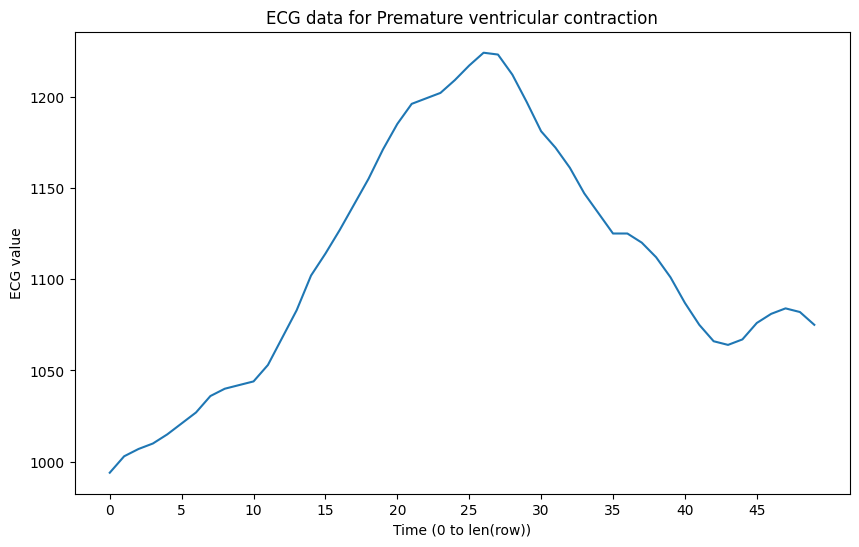

In [22]:
def visualize_row_by_value(df, value, figsize=(10, 6)):
    arrhythmia_types = {0: 'Normal beat', 1: 'Left bundle branch block beat', 2: 'Right bundle branch block beat', 3: 'Atrial premature beat', 4: 'Premature ventricular contraction'}
    filtered_df = df[df.iloc[:, -1] == value]
    plt.figure(figsize=figsize)
    selected_row = filtered_df.sample(n=1)
    plt.plot(range(len(selected_row.iloc[0, :-1])), selected_row.iloc[0, :-1].values, linestyle='-')
    plt.title(f'ECG data for {arrhythmia_types.get(value, "class " + str(value))}')
    plt.xlabel('Time (0 to len(row))')
    plt.ylabel('ECG value')
    plt.xticks(range(0, len(selected_row.iloc[0, :-1]), 5))  # Only show every 5th x tick
    plt.show()

visualize_row_by_value(data, 4)

## Train test split

In [23]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_res, y_res = undersampler.fit_resample(X, y)

df_res = pd.DataFrame(X_res, columns=X.columns)  
df_res['target'] = y_res
num_class = len(np.unique(y_res))

desired_size_per_class = 2000

data = pd.concat([
    df_class.sample(n=desired_size_per_class, random_state=42)
    for _, df_class in df_res.groupby('target')
])
data

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,target
10120,963,961,960,958,957,954,956,957,958,957,...,941,940,944,944,941,937,932,937,939,0
97501,948,947,944,946,942,941,940,943,944,942,...,939,933,931,931,929,930,930,930,929,0
74223,956,959,959,961,961,962,961,964,966,966,...,925,937,953,964,969,966,969,968,972,0
84433,914,913,917,913,918,921,924,926,928,931,...,894,898,900,899,900,898,895,896,896,0
89585,1005,1006,1010,1013,1019,1024,1034,1042,1053,1064,...,982,987,991,990,985,982,981,977,975,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43299,1003,1009,1014,1017,1018,1020,1024,1026,1030,1031,...,868,883,904,919,932,937,943,951,960,4
80608,1031,1040,1043,1045,1043,1048,1053,1063,1080,1093,...,1083,1083,1082,1076,1072,1068,1073,1086,1101,4
87109,964,972,980,985,997,1019,1044,1068,1085,1100,...,921,918,915,905,902,898,894,892,894,4
42491,1052,1058,1064,1069,1069,1062,1065,1077,1103,1122,...,929,933,932,930,931,931,930,935,935,4


In [31]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], train_size=0.7)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

## Model parameters

In [32]:
params = {
    'max_depth': 3,
    'learning_rate': 0.05, 
    'n_estimators': 1000,
    'subsample': 0.5,
    'objective': 'multiclass',
    'verbosity': -1,
    'num_class': num_class
}

model = lgb.LGBMClassifier(**params)
callbacks = [lgb.early_stopping(stopping_rounds=10, verbose=False)]

## Functions

In [33]:
pattern_df_train = pd.DataFrame(y_train, columns=['target'])
pattern_df_test = pd.DataFrame(y_test, columns=['target'])

def get_match_counts(params, X):
    pattern_length = int(params[0])
    start = int(params[1]) 
    end = int(params[2])
    stride = int(params[3])
    selected_area = X[:, start:end:stride]
    cct = params[4]
    pattern = np.array(params[5:(5 + pattern_length)])
    
    # Ensure valid dimensions
    window_size = len(pattern) * stride
    n_windows = max(0, (selected_area.shape[1] - window_size + stride) // stride)
    
    if n_windows <= 0:
        return np.zeros((X.shape[0], 1))
        
    # Create strided view of the data for efficient sliding window
    shape = (selected_area.shape[0], n_windows, len(pattern))
    strides = (selected_area.strides[0], selected_area.strides[1] * stride, selected_area.strides[1])
    windows = np.lib.stride_tricks.as_strided(selected_area, shape=shape, strides=strides)
    
    # Compute correlations efficiently using matrix operations
    means = windows.mean(axis=2, keepdims=True)
    stds = windows.std(axis=2, keepdims=True)
    stds[stds == 0] = 1  # Avoid division by zero
    normalized_windows = (windows - means) / stds
    pattern_norm = (pattern - pattern.mean()) / (pattern.std() or 1)
    correlations = np.abs(np.sum(normalized_windows * pattern_norm, axis=2) / len(pattern))
    
    return np.sum(correlations > cct, axis=1, keepdims=True)

def objective_function(params):
    if 'experimental_pattern' not in pattern_df_train.columns:
        pattern_df_train['experimental_pattern'] = 0.0
    pattern_df_train.loc[:, 'experimental_pattern'] = get_match_counts(params, X_train).ravel()
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        pattern_df_train.drop(['target'], axis=1).values,
        pattern_df_train['target'].values,
        test_size=0.15,
        random_state=42
    )
    model.fit(X_train_split, y_train_split,
             eval_set=[(X_val, y_val)],
             callbacks=callbacks)
    y_pred = model.predict(X_val)
    return -accuracy_score(y_val, y_pred)

In [34]:
# Define bounds for PSO
lb = [4, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] # width, start, end, stride, cct, pattern
ub = [8, len(X_train[0])-5, len(X_train[0]), 4, 1, 1, 1, 1, 1, 1, 1, 1, 1] # width, start, end, stride, cct, pattern

# Run PSO with increased swarmsize and reduced maxiter for faster convergence
optimal_params = []
for i in range(2):
    xopt, fopt = pso(objective_function, lb, ub, swarmsize=50, maxiter=10, debug=False)
    optimal_params.append(xopt)
    new_pattern_train = get_match_counts(xopt, X_train).flatten()
    new_pattern_test = get_match_counts(xopt, X_test).flatten()
    pattern_df_train = pd.concat([pattern_df_train, pd.Series(new_pattern_train, name=f'pattern_{i+1}')], axis=1)
    pattern_df_train.drop('experimental_pattern', axis=1, inplace=True)
    pattern_df_test = pd.concat([pattern_df_test, pd.Series(new_pattern_test, name=f'pattern_{i+1}')], axis=1)
    print("Optimal objective value:", fopt)

Stopping search: maximum iterations reached --> 10
Optimal objective value: -0.46
Stopping search: maximum iterations reached --> 10
Optimal objective value: -0.5733333333333334


In [30]:
optimal_params

[array([4.78520196e+00, 0.00000000e+00, 5.00000000e+01, 2.49710234e+00,
        4.29560548e-01, 1.20348799e-01, 8.56624472e-01, 6.67030737e-01,
        1.35679015e-01, 7.67224948e-01, 5.10490466e-01, 6.61592152e-01,
        4.02090476e-02]),
 array([ 5.21028655, 13.41726599, 40.53401493,  2.62991519,  0.5432254 ,
         0.37890083,  0.        ,  0.81925018,  0.95471486,  0.28218104,
         0.48280565,  0.23474265,  0.31147965])]

In [29]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    pattern_df_train.drop(['target'], axis=1).values,
    pattern_df_train['target'].values,
    test_size=0.15,
    random_state=42
)
model.fit(X_train_split, y_train_split,
            eval_set=[(X_val, y_val)],
            callbacks=callbacks)
y_pred = model.predict(pattern_df_test.drop('target', axis=1))
accuracy = accuracy_score(y_pred, pattern_df_test['target'])
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.42
